In [1]:
# get the environment
import sys
print(sys.version)
print(sys.executable)
import os
os.getcwd()

3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]
C:\Users\bbutler\Documents\Anaconda3\envs\reticulate\python.exe


'C:\\Users\\bbutler\\Documents\\DataScience\\NLP'

In [2]:
# Standard imports
import sys
import warnings
warnings.simplefilter('ignore')
import os
import pandas as pd
import numpy as np


# plotting
import textwrap
import matplotlib.pyplot as plt
import seaborn as sns
# improve with plotly
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
print('Seaborn Version: ', sns.__version__)
# get UMAP for dimension reduction
import umap


%matplotlib inline

# for dendograms
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy

# get the lDA algorithm
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

# text libraries
import nltk
from wordcloud import WordCloud, STOPWORDS# preprocessing prior to lda
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# use the TF-IDF vectorizor to give more weight to rare words
# TF-IDF specific setup
from sklearn.feature_extraction.text import TfidfVectorizer

# set seed for reproducibility
SEED = 42

0.11.1


In [3]:
# TF imports
import tensorflow_hub as hub
import tensorflow as tf

In [4]:
# Load the GUSE model
guse = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [5]:
# get the data
data = pd.read_csv('Transaction_Survey.csv', low_memory=False)
data.head()

Respondent Id          Completed Date        CIS  Event_Trigger  \
0        5838490  01/08/2021 12:44:28 PM  2160715.0  accountsEvent   
1        5838485  01/08/2021 12:25:57 PM   696492.0  accountsEvent   
2        5838482  01/08/2021 12:14:21 PM  2069130.0  accountsEvent   
3        5838481  01/08/2021 12:14:17 PM    98647.0  accountsEvent   
4        5838480  01/08/2021 12:13:56 PM   342217.0   depositEvent   

  What best describes your experience?* Please say more.         OS DeviceType  
0                         Fast and easy              NaN   iOS 14.2      Phone  
1                         Fast and easy              NaN    Android      Phone  
2                         Fast and easy              NaN   iOS 13.7      Phone  
3             Just OK - needs some work              NaN   iOS 14.3      Phone  
4                         Fast and easy              NaN  Android 7      Phone

In [6]:
data['Event_Trigger'].value_counts()

accountsEvent    6879
transferEvent    3070
depositEvent     2952
billpayEvent      639
Name: Event_Trigger, dtype: int64

In [7]:
data['OS'].value_counts()

Android          5422
iOS 14.2         4638
iOS 14.3          693
iOS 14.2.1        357
Android 8         303
iOS 14.1          219
Android 8.1       213
iOS 13.7          187
iOS 14            152
iOS 12.4.9        143
Android 7         133
iOS 13.6.1        106
iOS 13.5.1         62
Android 6          56
Android 7.1.1      53
iOS 13.6           42
iOS 13.3.1         31
iOS 12.5           19
iOS 14.4           15
iOS 13.3           15
iOS 13.4.1         14
iOS 12.4.8         10
iOS 12.4.1         10
iOS 13.1.2          9
iOS 12.2            7
Android 5.1.1       7
iOS 12.4            6
iOS 12.1.4          5
iOS 13.5            5
iOS 11.4.1          5
Android 5           5
iOS 12.3.1          5
Android 7.1.2       5
iOS 11              4
iOS 13.1.3          4
iOS 12.4.5          3
iOS 12              3
iOS 12.1            3
iOS 10.3.3          2
iOS 13.2            2
iOS 11.3            2
iOS 11.2.5          2
iOS 10.2.1          2
iOS 10.3.2          2
iOS 11.4            1
iOS 12.3  

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13541 entries, 0 to 13540
Data columns (total 8 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Respondent Id                          13541 non-null  int64  
 1   Completed Date                         13541 non-null  object 
 2   CIS                                    13540 non-null  float64
 3   Event_Trigger                          13540 non-null  object 
 4   What best describes your experience?*  13541 non-null  object 
 5   Please say more.                       1642 non-null   object 
 6   OS                                     12993 non-null  object 
 7   DeviceType                             12993 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 846.4+ KB


In [9]:
# regroup the OS

def get_os(row):
    if pd.isnull(row):
        return 'None'
    elif "Android" in row:
        return row[0:10]
    else:
        return row[0:7]

In [10]:
data['OS_Group'] = data['OS'].apply(get_os)
data.head(10)

Respondent Id          Completed Date        CIS  Event_Trigger  \
0        5838490  01/08/2021 12:44:28 PM  2160715.0  accountsEvent   
1        5838485  01/08/2021 12:25:57 PM   696492.0  accountsEvent   
2        5838482  01/08/2021 12:14:21 PM  2069130.0  accountsEvent   
3        5838481  01/08/2021 12:14:17 PM    98647.0  accountsEvent   
4        5838480  01/08/2021 12:13:56 PM   342217.0   depositEvent   
5        5838479  01/08/2021 12:12:24 PM   313322.0  accountsEvent   
6        5838477  01/08/2021 12:06:29 PM  2437716.0  transferEvent   
7        5838474  01/08/2021 12:04:55 PM  1800213.0   depositEvent   
8        5838473  01/08/2021 12:02:29 PM  2214898.0  transferEvent   
9        5838471  01/08/2021 12:01:09 PM  1790762.0   depositEvent   

  What best describes your experience?* Please say more.         OS  \
0                         Fast and easy              NaN   iOS 14.2   
1                         Fast and easy              NaN    Android   
2                         Fast and easy              NaN   iOS 13.7   
3             Just OK - needs some work              NaN   iOS 14.3   
4                         Fast and easy              NaN  Android 7   
5                               Not now              NaN    Android   
6                               Not now              NaN    Android   
7                               Not now              NaN    Android   
8                               Not now              NaN     iOS 14   
9                               Not now              NaN   iOS 14.2   

  DeviceType   OS_Group  
0      Phone    iOS 14.  
1      Phone    Android  
2      Phone    iOS 13.  
3      Phone    iOS 14.  
4      Phone  Android 7  
5      Phone    Android  
6      Phone    Android  
7      Phone    Android  
8      Phone     iOS 14  
9      Phone    iOS 14.

In [11]:
# remove the extra periods
data['OS_Group'] = data['OS_Group'].str.replace('.', '')
data.head(10)

Respondent Id          Completed Date        CIS  Event_Trigger  \
0        5838490  01/08/2021 12:44:28 PM  2160715.0  accountsEvent   
1        5838485  01/08/2021 12:25:57 PM   696492.0  accountsEvent   
2        5838482  01/08/2021 12:14:21 PM  2069130.0  accountsEvent   
3        5838481  01/08/2021 12:14:17 PM    98647.0  accountsEvent   
4        5838480  01/08/2021 12:13:56 PM   342217.0   depositEvent   
5        5838479  01/08/2021 12:12:24 PM   313322.0  accountsEvent   
6        5838477  01/08/2021 12:06:29 PM  2437716.0  transferEvent   
7        5838474  01/08/2021 12:04:55 PM  1800213.0   depositEvent   
8        5838473  01/08/2021 12:02:29 PM  2214898.0  transferEvent   
9        5838471  01/08/2021 12:01:09 PM  1790762.0   depositEvent   

  What best describes your experience?* Please say more.         OS  \
0                         Fast and easy              NaN   iOS 14.2   
1                         Fast and easy              NaN    Android   
2                         Fast and easy              NaN   iOS 13.7   
3             Just OK - needs some work              NaN   iOS 14.3   
4                         Fast and easy              NaN  Android 7   
5                               Not now              NaN    Android   
6                               Not now              NaN    Android   
7                               Not now              NaN    Android   
8                               Not now              NaN     iOS 14   
9                               Not now              NaN   iOS 14.2   

  DeviceType   OS_Group  
0      Phone     iOS 14  
1      Phone    Android  
2      Phone     iOS 13  
3      Phone     iOS 14  
4      Phone  Android 7  
5      Phone    Android  
6      Phone    Android  
7      Phone    Android  
8      Phone     iOS 14  
9      Phone     iOS 14

In [12]:
data['OS_Group'].value_counts()

iOS 14       6074
Android      5422
None          548
Android 8     516
iOS 13        480
iOS 12        218
Android 7     191
Android 6      56
iOS 11         16
Android 5      13
iOS 10          7
Name: OS_Group, dtype: int64

In [13]:
text = data[['Please say more.', 'OS_Group']]
text.head()

Please say more.   OS_Group
0              NaN     iOS 14
1              NaN    Android
2              NaN     iOS 13
3              NaN     iOS 14
4              NaN  Android 7

In [14]:
# rename the colum
text.columns = ["Comments", 'OS']
text.head()

Comments         OS
0      NaN     iOS 14
1      NaN    Android
2      NaN     iOS 13
3      NaN     iOS 14
4      NaN  Android 7

In [15]:
# lots of NaN only get clean text
df = text[text['Comments'].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1642 entries, 13 to 13538
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Comments  1642 non-null   object
 1   OS        1642 non-null   object
dtypes: object(2)
memory usage: 38.5+ KB


# Use a Count Vectorizer for Processing Comments into Bigrams

In [16]:
# max_df - discard words that show up in x percent of documents has a scale 0 - 1
# min_df - is the opposite, minimum frequency can be a percent or raw number of documents
# ngram_range is normally (1,1) for single words, 2,2, for bigrams

cv = CountVectorizer(max_df = 0.95, min_df=2, stop_words='english', ngram_range=(2, 2))

In [17]:
# make document term matrix
dtm = cv.fit_transform(df['Comments'])
dtm

<1642x483 sparse matrix of type '<class 'numpy.int64'>'
	with 1994 stored elements in Compressed Sparse Row format>

In [18]:
dtm.shape

(1642, 483)

In [19]:
# convert to dataframe for clustering
bow = pd.DataFrame(dtm.toarray(), columns = cv.get_feature_names())
bow

1st time  20 years  30 years  able access  able balance  able check  \
0            1         0         0            0             0           0   
1            0         0         0            0             0           0   
2            0         0         0            0             0           0   
3            0         0         0            0             0           0   
4            0         0         0            0             0           0   
...        ...       ...       ...          ...           ...         ...   
1637         0         0         0            0             0           0   
1638         0         0         0            0             0           0   
1639         0         0         0            0             0           0   
1640         0         0         0            0             0           0   
1641         0         0         0            0             0           0   

      able complete  able deposit  able sign  access account  ...  work time  \
0                 0             0          0               0  ...          0   
1                 0             0          0               0  ...          0   
2                 0             0          0               0  ...          0   
3                 0             0          0               0  ...          0   
4                 0             0          0               0  ...          0   
...             ...           ...        ...             ...  ...        ...   
1637              0             0          0               0  ...          0   
1638              0             0          0               0  ...          0   
1639              0             0          0               0  ...          0   
1640              0             0          0               0  ...          0   
1641              0             0          0               0  ...          0   

      worked fine  worked great  works easy  works fine  works great  \
0               0             0           0           0            0   
1               0             0           0           0            0   
2               0             0           0           0            0   
3               0             0           0           0            0   
4               0             0           0           0            0   
...           ...           ...         ...         ...          ...   
1637            0             0           0           0            0   
1638            0             0           0           0            0   
1639            0             0           0           0            0   
1640            0             0           0           0            1   
1641            0             0           0           0            0   

      works nice  works nicely  works ok  year ago  
0              0             0         0         0  
1              0             0         0         0  
2              0             0         0         0  
3              0             0         0         0  
4              0             0         0         0  
...          ...           ...       ...       ...  
1637           0             0         0         0  
1638           0             0         0         0  
1639           0             0         0         0  
1640           0             0         0         0  
1641           0             0         0         1  

[1642 rows x 483 columns]

In [20]:
bow['OS'] = df['OS']

In [21]:
# collapse it down
osDf = bow.groupby(['OS']).sum()
osDf

1st time  20 years  30 years  able access  able balance  \
OS                                                                   
Android           0         0         0            0             0   
Android 6         0         0         0            0             0   
Android 7         0         0         0            0             0   
Android 8         0         0         0            0             0   
None              0         0         0            0             0   
iOS 11            0         0         0            0             0   
iOS 12            0         0         0            0             0   
iOS 13            0         0         0            0             0   
iOS 14            0         0         0            0             0   

           able check  able complete  able deposit  able sign  access account  \
OS                                                                              
Android             0              0             0          0               0   
Android 6           0              0             0          0               0   
Android 7           0              0             0          0               0   
Android 8           0              0             0          0               0   
None                0              0             0          0               0   
iOS 11              0              0             0          0               0   
iOS 12              0              0             0          0               0   
iOS 13              0              0             0          0               0   
iOS 14              0              0             1          1               0   

           ...  work time  worked fine  worked great  works easy  works fine  \
OS         ...                                                                 
Android    ...          0            0             0           0           1   
Android 6  ...          0            0             0           0           0   
Android 7  ...          0            0             0           0           0   
Android 8  ...          0            0             0           0           0   
None       ...          0            0             0           0           0   
iOS 11     ...          0            0             0           0           0   
iOS 12     ...          0            0             0           0           0   
iOS 13     ...          0            0             0           0           0   
iOS 14     ...          0            0             0           0           0   

           works great  works nice  works nicely  works ok  year ago  
OS                                                                    
Android              0           1             0         0         0  
Android 6            0           0             0         0         0  
Android 7            0           0             0         0         0  
Android 8            0           0             0         0         0  
None                 1           0             0         0         0  
iOS 11               0           0             0         0         0  
iOS 12               0           0             0         0         0  
iOS 13               0           0             0         0         0  
iOS 14               0           0             0         0         0  

[9 rows x 483 columns]

In [22]:
# Calculate the distance between each sample
Z = linkage(osDf, 'ward')

In [23]:
l = list(osDf.index)
l

['Android',
 'Android 6',
 'Android 7',
 'Android 8',
 'None',
 'iOS 11',
 'iOS 12',
 'iOS 13',
 'iOS 14']

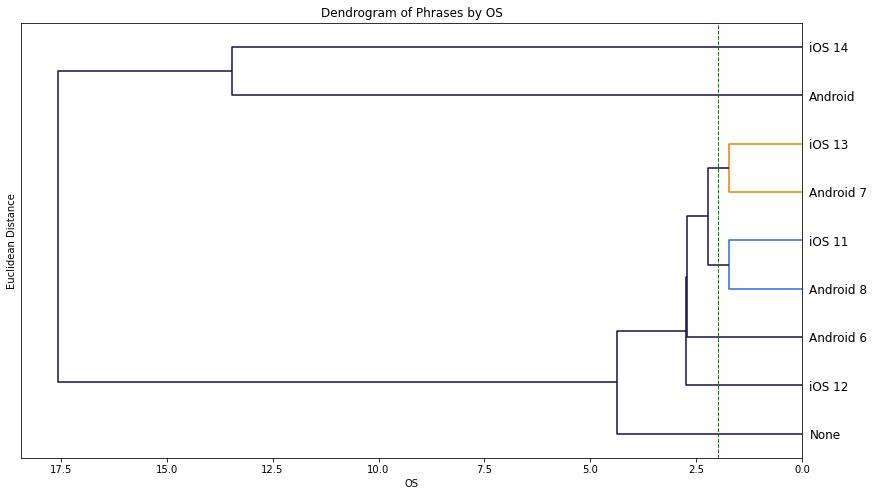

In [24]:
# Make the dendrogram
# # Set the colour of the cluster here:
# hierarchy.set_link_color_palette(['#b30000','#996600', '#b30086'])
# colors = ["#2A66DE", "#E88202", "#2A66DE", "#E88202"]
hierarchy.set_link_color_palette(["#2A66DE", "#E88202"]) 

# set the threshold to color
t = 2.0

plt.figure(figsize=(14,8))
dendrogram(Z, labels=l, leaf_rotation=0, leaf_font_size=12,
           orientation="left",
           color_threshold=t,
           above_threshold_color="#180A47")
plt.axvline(x=t, c='green', lw=1, linestyle='dashed')
plt.title('Dendrogram of Phrases by OS')
plt.xlabel('OS')
plt.ylabel('Euclidean Distance')
plt.show()

# Perform Topic Modeling with LDA


In [25]:
# function to do a grid search of params
def cv_lda(data_in):
    search_params = {'n_components':[4, 6, 8], "learning_decay":[0.3, 0.5, 0.7]}
    
    # initialize model
    LDA = LatentDirichletAllocation(random_state = SEED)
    
    # init grid search class
    model = GridSearchCV(LDA, param_grid = search_params).fit(data_in)
    
    # return best model
    print("Best Model's Params: ", model.best_params_)
    print("\nBest Log Likelihood: ", model.best_score_)
    print("\nBest Perplexity: ", model.best_estimator_.perplexity(data_in))
    model.best_estimator_

In [26]:
model = cv_lda(dtm)

Best Model's Params:  {'learning_decay': 0.3, 'n_components': 4}

Best Log Likelihood:  -3498.3614761085746

Best Perplexity:  523.5051147279124


In [27]:
LDA = LatentDirichletAllocation(n_components=4, random_state=SEED, learning_decay=0.3)
LDA.fit(dtm)

LatentDirichletAllocation(learning_decay=0.3, n_components=4, random_state=42)

In [28]:
# grab the vocabulary of words
len(cv.get_feature_names())

483

In [29]:
LDA.components_.shape

(4, 483)

In [30]:
# get one topic
single_topic = LDA.components_[0]

In [31]:
# take a look
top_twenty_words = single_topic.argsort()[-20:]

# get thet top 20
for index in top_twenty_words:
    print(cv.get_feature_names()[index])

love easy
customer service
bank easy
great easy
happy holidays
easy navigate
easy thank
app doesn
easy convenient
banking app
quick easy
good work
best bank
merry christmas
depositing checks
good service
good app
fast easy
eastern bank
love eastern


In [32]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 20 BIGRAMS WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-20:]])
    print('\n')

THE TOP 20 BIGRAMS WORDS FOR TOPIC #0
['love easy', 'customer service', 'bank easy', 'great easy', 'happy holidays', 'easy navigate', 'easy thank', 'app doesn', 'easy convenient', 'banking app', 'quick easy', 'good work', 'best bank', 'merry christmas', 'depositing checks', 'good service', 'good app', 'fast easy', 'eastern bank', 'love eastern']


THE TOP 20 BIGRAMS WORDS FOR TOPIC #1
['works great', 've used', 'debit card', 'experience eastern', 'great work', 'happy eastern', 'easy deposit', 'banking eastern', 'happy new', 'new year', 'checking account', 'app great', 'online banking', 'like app', 'bank app', 'easy navigate', 'app works', 'great service', 'great app', 'eastern bank']


THE TOP 20 BIGRAMS WORDS FOR TOPIC #2
['works great', 'site easy', 'app simple', 'convenient easy', 'don use', 'far good', 'great bank', 'doesn work', 'check deposits', 'app convenient', 'nice easy', 'love online', 'customer service', 'deposit checks', 'love mobile', 'love bank', 'online banking', 'mobil

In [33]:
topic_results = LDA.transform(dtm)
topic_results.shape

(1642, 4)

In [34]:
# get the first row, has probabilities of each topic
topic_results[0].round(2)

array([0.08, 0.08, 0.75, 0.09])

In [35]:
# get index position of highest probability
# use it to assign the topic to the phrases

topic_results[0].argmax()

2

In [36]:
# create a column for the topic assignment

df['Topic'] = topic_results.argmax(axis=1)
df.head(10)

Comments         OS  Topic
13  This time was great.  The 1st time I tried the...  Android 8      2
14  It should provide more space, where the dollar...    Android      0
19                                               Yeah     iOS 14      0
30  Loading times for landing page are excessive. ...  Android 8      1
36                                         Easy peasy     iOS 14      2
37  With technology as it is we should be able to ...    Android      0
48  I love the direct deposit feature and acct tra...     iOS 14      3
58       Everything performed the way it should have.     iOS 14      0
69  Mobile app works great.  Desktop app is painfu...     iOS 14      2
83                                That would be great    Android      0

In [37]:
# map with words this is just a high level pass you'll have to study it more
mytopic_dict = {0:'online banking',1:'app use',2:'experience',3:'eastern bank',}

df['Topic Label'] = df['Topic'].map(mytopic_dict)
df.head(10)

Comments         OS  Topic  \
13  This time was great.  The 1st time I tried the...  Android 8      2   
14  It should provide more space, where the dollar...    Android      0   
19                                               Yeah     iOS 14      0   
30  Loading times for landing page are excessive. ...  Android 8      1   
36                                         Easy peasy     iOS 14      2   
37  With technology as it is we should be able to ...    Android      0   
48  I love the direct deposit feature and acct tra...     iOS 14      3   
58       Everything performed the way it should have.     iOS 14      0   
69  Mobile app works great.  Desktop app is painfu...     iOS 14      2   
83                                That would be great    Android      0   

       Topic Label  
13      experience  
14  online banking  
19  online banking  
30         app use  
36      experience  
37  online banking  
48    eastern bank  
58  online banking  
69      experience  
83  online banking

# Sentiment Analysis

In [38]:
# instantiate sentiment engine
sid = SentimentIntensityAnalyzer()

In [39]:

# apply the sentiment analyzer
df['scores'] = df['Comments'].apply(lambda review: sid.polarity_scores(review))

# compound scores
df['compound'] = df['scores'].apply(lambda d:d['compound'])
df.head()

Comments         OS  Topic  \
13  This time was great.  The 1st time I tried the...  Android 8      2   
14  It should provide more space, where the dollar...    Android      0   
19                                               Yeah     iOS 14      0   
30  Loading times for landing page are excessive. ...  Android 8      1   
36                                         Easy peasy     iOS 14      2   

       Topic Label                                             scores  \
13      experience  {'neg': 0.0, 'neu': 0.76, 'pos': 0.24, 'compou...   
14  online banking  {'neg': 0.044, 'neu': 0.801, 'pos': 0.155, 'co...   
19  online banking  {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...   
30         app use  {'neg': 0.0, 'neu': 0.813, 'pos': 0.187, 'comp...   
36      experience  {'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'comp...   

    compound  
13    0.6249  
14    0.6115  
19    0.2960  
30    0.3182  
36    0.4404

In [40]:
# add some context
# you can choose scores fore neutral (-1 to 1 or something like that)
def sentiment_score(row):
    if row > .25:
        return 'Pos'
    elif row < -.25:
        return 'Neg'
    else:
        return "Neu"

In [41]:
df['sentiment'] = df['compound'].apply(sentiment_score)

df.head()

Comments         OS  Topic  \
13  This time was great.  The 1st time I tried the...  Android 8      2   
14  It should provide more space, where the dollar...    Android      0   
19                                               Yeah     iOS 14      0   
30  Loading times for landing page are excessive. ...  Android 8      1   
36                                         Easy peasy     iOS 14      2   

       Topic Label                                             scores  \
13      experience  {'neg': 0.0, 'neu': 0.76, 'pos': 0.24, 'compou...   
14  online banking  {'neg': 0.044, 'neu': 0.801, 'pos': 0.155, 'co...   
19  online banking  {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...   
30         app use  {'neg': 0.0, 'neu': 0.813, 'pos': 0.187, 'comp...   
36      experience  {'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'comp...   

    compound sentiment  
13    0.6249       Pos  
14    0.6115       Pos  
19    0.2960       Pos  
30    0.3182       Pos  
36    0.4404       Pos

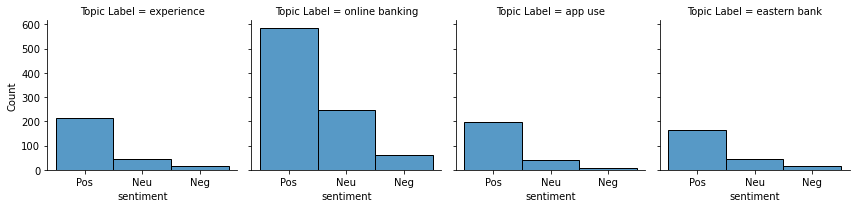

In [42]:
sns.displot(
    df, x="sentiment", col="Topic Label",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
)

In [43]:
# you can select by topic too
# you'll need to maintain the oder of topic labels, etc. or just do the dtm
# the dtm was created in the earlier step, you can create a new one based on slicing the above dataframe

cv.vocabulary_

{'1st time': 0,
 'tried picture': 428,
 'loading times': 280,
 'easy peasy': 189,
 'deposit feature': 145,
 'mobile app': 306,
 'app works': 55,
 'works great': 478,
 'paying bills': 343,
 'long time': 282,
 'multiple payments': 317,
 'multiple bills': 316,
 'bills time': 102,
 'eastern online': 174,
 'online banking': 337,
 'banking platform': 94,
 've issues': 460,
 'eastern bank': 173,
 'bank wish': 82,
 'worked great': 475,
 'bank eastern': 72,
 'eastern app': 172,
 'app allows': 22,
 'love eastern': 288,
 'just wish': 265,
 'atm fees': 58,
 'banking app': 84,
 'app use': 51,
 'easy navigate': 187,
 'think great': 412,
 'need thank': 323,
 'pretty good': 353,
 'didn work': 154,
 'depositing checks': 151,
 'mobile deposit': 310,
 'great app': 228,
 'real time': 362,
 'great work': 240,
 'easy fast': 180,
 'using mobile': 455,
 'user friendly': 451,
 'friendly convenient': 219,
 'deposit limit': 146,
 'business checking': 107,
 'face id': 210,
 'does work': 159,
 'work time': 473,
 '

In [44]:
# get the phrases from the dtm 
sum_words = dtm.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
print (words_freq[:100])

[('eastern bank', 118), ('easy use', 95), ('love app', 44), ('love eastern', 43), ('fast easy', 37), ('online banking', 30), ('app easy', 29), ('mobile app', 27), ('user friendly', 26), ('easy navigate', 23), ('great app', 20), ('great service', 20), ('app works', 19), ('bank app', 19), ('mobile deposit', 17), ('deposit check', 16), ('love bank', 15), ('good app', 15), ('check deposit', 15), ('customer service', 14), ('deposit checks', 13), ('use app', 12), ('banking app', 11), ('like app', 11), ('merry christmas', 11), ('love mobile', 11), ('depositing checks', 10), ('good experience', 10), ('good service', 10), ('app great', 10), ('works great', 9), ('easy fast', 9), ('simple easy', 9), ('good work', 9), ('best bank', 9), ('quick easy', 9), ('using app', 9), ('easy convenient', 8), ('nice easy', 8), ('love online', 8), ('banking eastern', 8), ('long time', 7), ('easy deposit', 7), ('mobile banking', 7), ('checking account', 7), ('banking easy', 7), ('app convenient', 7), ('like able'

In [45]:
# set the stopwords list

stopwords = set(STOPWORDS)

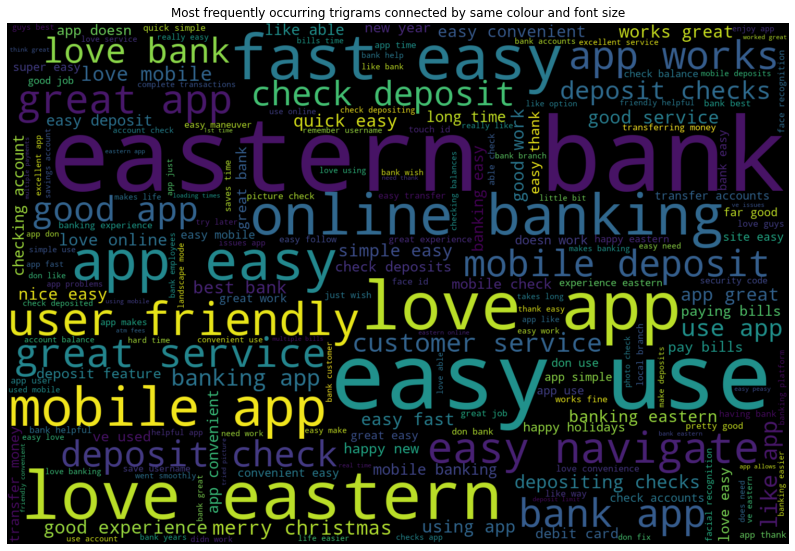

In [46]:
# Generating wordcloud and saving as jpg image
plt.figure(figsize=(14,10))

words_dict = dict(words_freq)
WC_height = 1000
WC_width = 1500
WC_max_words = 200
wordCloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width,stopwords=stopwords)
wordCloud.generate_from_frequencies(words_dict)
plt.title('Most frequently occurring trigrams connected by same colour and font size')
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# save to file
# wordCloud.to_file('wordcloud_bigram.jpg')

# Topic Plot

In [47]:
 # Generate the TF-IDF vectors
# this is the same step as earlier with the count vectorizer
vectorizer_tfidf = TfidfVectorizer(max_features=10000, ngram_range = (2,2))
vectors_tfidf = vectorizer_tfidf.fit_transform(df.Comments)
print(vectors_tfidf.shape)

(1642, 7850)


In [48]:
# Generate the TF-IDF dimension reduction
embedding_tfidf = umap.UMAP(random_state=SEED).fit_transform(vectors_tfidf)

In [49]:
def enable_plotly_in_cell():
  import IPython
  display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
  init_notebook_mode(connected=False)

In [50]:
# set up plotting

df['x'] = embedding_tfidf[:,0]
df['y'] = embedding_tfidf[:,1]

In [51]:
# Wrap the text so it displays nicely in Plotly hover
df['wrap'] = df['Comments'].map(lambda x: '<br>'.join(textwrap.wrap(x, 64)))

In [52]:
enable_plotly_in_cell()
DIMENSION = 'Topic'

layout = go.Layout(
    autosize=False,
    width=600,
    height=600,
    hovermode="closest"
)

data = [go.Scatter(
                x=df.x,
                y=df.y,
                text=df.wrap,
                mode='markers',
                marker=dict(
                        size=6,
                        colorscale='viridis',
                        color=df[DIMENSION],
                        showscale=True
                )
                )]

fig = go.Figure(data=data, layout=layout)

iplot(fig)

# Deep Learning Model with GUSE
## Google Universal Sentence Encoder using Tensorflow

In [53]:
# convert main text field to a list
# make each column a separate list

text = df['Comments'].to_list()
len(text)

1642

In [54]:
# get the sentences
# np_list = np.asarray(sentence_list) and then convert it to tensor using
# tensor_list = tf.convert_to_tensor(np_list)

np_list = np.asarray(text)
sentences = tf.convert_to_tensor(np_list)
sentences

<tf.Tensor: shape=(1642,), dtype=string, numpy=
array([b'This time was great.  The 1st time I tried the back picture was a bit clunky.',
       b'It should provide more space, where the dollar amount goes. On my phone is so close to the account being displayed, easily to miss. But the rest is very easy to do.',
       b'Yeah', ..., b'Good experience', b'Works great.',
       b'Interface can be sluggish. Noticed that quality of the app has improved since the rollout; far less buggy than a year ago.'],
      dtype=object)>

In [55]:
end = sentences.shape
end

TensorShape([1642])

In [56]:
# encode them all
vectors_guse = guse(sentences)
print(vectors_guse.shape)

(1642, 512)


In [57]:
# Generate the GUSE dimension reductions
embedding_guse = umap.UMAP(random_state=SEED).fit_transform(vectors_guse)

In [58]:
embedding_guse.shape

(1642, 2)

In [59]:
# set up plotting

df['x'] = embedding_guse[:,0]
df['y'] = embedding_guse[:,1]

In [60]:
enable_plotly_in_cell()
DIMENSION = 'Topic'

layout = go.Layout(
    autosize=False,
    width=600,
    height=600,
    hovermode="closest"
)

data = [go.Scatter(
                x=df.x,
                y=df.y,
                text=df.wrap,
                mode='markers',
                marker=dict(
                        size=6,
                        colorscale='viridis',
                        color=df[DIMENSION],
                        showscale=True
                )
                )]

fig = go.Figure(data=data, layout=layout)

iplot(fig)